In [30]:
# importei o pandas para transformar o arquivo que estava em excel para csv 
import pandas as pd
# importação do spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, month, to_date, sum

In [31]:
# Criando a sessão Spark
spark = SparkSession.builder.appName("Desafio_Rox").config("spark.jars.packages", "org.postgresql:postgresql:42.2.24").getOrCreate()

## Transformando o arquivo excel em csvtop_itens_pd

In [33]:
# lendo o arquivo excel
read_file = pd.read_excel('./data/raw/sales_data.csv.xlsx')
# Tranformando em csv
read_file.to_csv("./data/refined/sales_data.csv", index = None, header=True) 

In [53]:
# lendo o arquivo excel
read_file = pd.read_excel('./data/raw/customer_data.xlsx')
# Tranformando em csv
read_file.to_csv("./data/refined/customer_data.csv", index = None, header=True) 

## Começando a análise

In [36]:
# criando um dataframe no spark do sales_data
data = spark.read.csv('./data/refined/sales_data.csv', header=True, inferSchema=True)

In [37]:
# Exibindo as primeiras 5 linhas do dataframe para conferir se está tudo certo
data.show(5)

+--------+------------+--------+----------+----------+-------------------+
|order_id|product_name|quantity|unit_price|cliente_id|         order_date|
+--------+------------+--------+----------+----------+-------------------+
|       1|   Produto A|       3|        25|        74|2024-03-01 00:00:00|
|       2|   Produto B|       2|        30|        36|2024-03-02 00:00:00|
|       3|   Produto C|       1|        20|        12|2024-03-03 00:00:00|
|       4|   Produto A|       4|        25|        92|2024-03-04 00:00:00|
|       5|   Produto D|       2|        40|        55|2024-03-05 00:00:00|
+--------+------------+--------+----------+----------+-------------------+
only showing top 5 rows



In [38]:
# vendo as informações gerais
data.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- unit_price: integer (nullable = true)
 |-- cliente_id: integer (nullable = true)
 |-- order_date: timestamp (nullable = true)



In [39]:
# vendo mais algumas informaões importantes
data.describe().show()

+-------+------------------+------------+------------------+-----------------+------------------+
|summary|          order_id|product_name|          quantity|       unit_price|        cliente_id|
+-------+------------------+------------+------------------+-----------------+------------------+
|  count|               100|         100|               100|              100|               100|
|   mean|              50.5|        null|              2.34|             28.6|             49.12|
| stddev|29.011491975882016|        null|0.9766982102673242|7.353965466386694|29.403593541118624|
|    min|                 1|   Produto A|                 1|               20|                 1|
|    max|               100|   Produto D|                 4|               40|               100|
+-------+------------------+------------+------------------+-----------------+------------------+



In [40]:
# agrupando por produtos e agregando uma soma da coluna quantidades
top_itens = data.groupBy('product_name').agg(sum('quantity'))
# ordenando os resultados por ordem descendente para ficar melhor a visualização
top_itens = top_itens.orderBy(col('sum(quantity)').desc())
# mostrando os principais produtos
top_itens.show()

+------------+-------------+
|product_name|sum(quantity)|
+------------+-------------+
|   Produto A|           61|
|   Produto B|           60|
|   Produto C|           60|
|   Produto D|           53|
+------------+-------------+



In [41]:
# adicionando uma coluna, que vai receber o resultado da multiplicação dos itens da coluna 'quantity' e da coluna 'unit_price'
data_total_amount = data.withColumn('total_amount', col('quantity') * col('unit_price'))

In [42]:
# mostrando o resultado
data_total_amount.show()

+--------+------------+--------+----------+----------+-------------------+------------+
|order_id|product_name|quantity|unit_price|cliente_id|         order_date|total_amount|
+--------+------------+--------+----------+----------+-------------------+------------+
|       1|   Produto A|       3|        25|        74|2024-03-01 00:00:00|          75|
|       2|   Produto B|       2|        30|        36|2024-03-02 00:00:00|          60|
|       3|   Produto C|       1|        20|        12|2024-03-03 00:00:00|          20|
|       4|   Produto A|       4|        25|        92|2024-03-04 00:00:00|         100|
|       5|   Produto D|       2|        40|        55|2024-03-05 00:00:00|          80|
|       6|   Produto B|       3|        30|        27|2024-03-06 00:00:00|          90|
|       7|   Produto C|       2|        20|        83|2024-03-07 00:00:00|          40|
|       8|   Produto A|       1|        25|        18|2024-03-08 00:00:00|          25|
|       9|   Produto D|       3|

In [43]:
# agrupando por cliente e calculando a soma do valor total dos pedidos
top_customers = data_total_amount.groupBy('cliente_id').agg(sum('total_amount').alias('total_spent'))

# ordenando os clientes pelo valor total gasto em ordem decrescente
top_customers = top_customers.orderBy(col('total_spent').desc())

# mostrando os top 10 clientes
top_customers.show(10)

+----------+-----------+
|cliente_id|total_spent|
+----------+-----------+
|         8|        270|
|        76|        250|
|         6|        230|
|        12|        220|
|        50|        200|
|        39|        200|
|        42|        180|
|        52|        170|
|        45|        170|
|        96|        160|
+----------+-----------+
only showing top 10 rows



## Vizualização dos dados

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

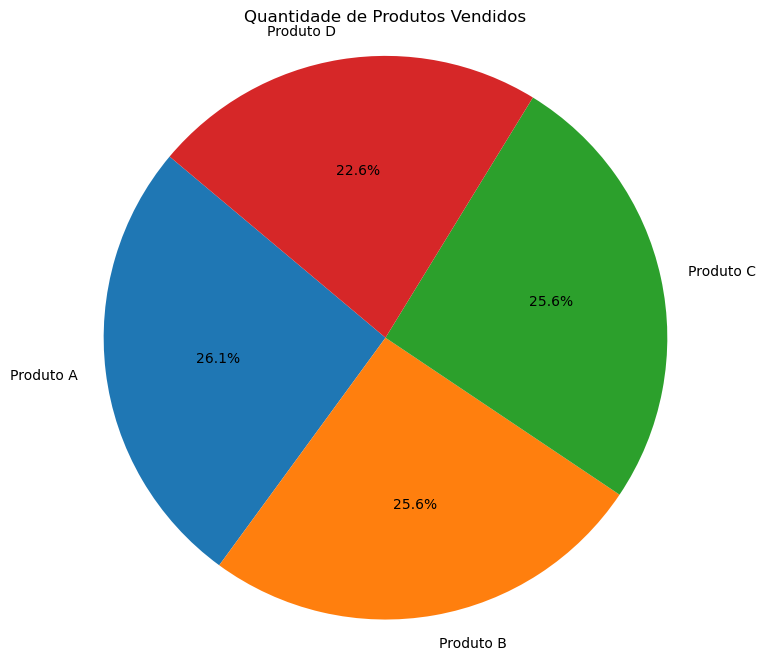

In [52]:
top_itens_pd = top_itens.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(top_itens_pd['sum(quantity)'], labels=top_itens_pd['product_name'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Quantidade de Produtos Vendidos')
plt.show()

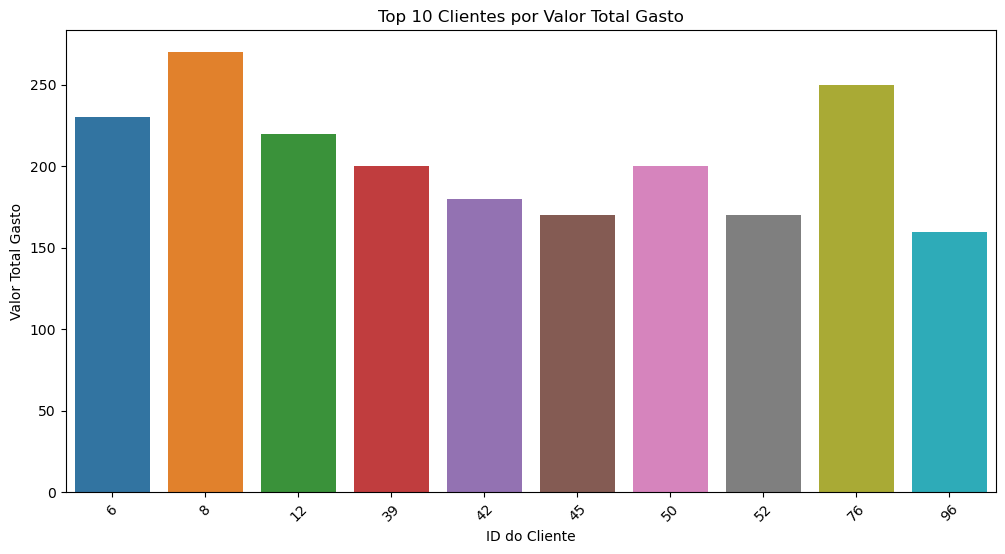

In [51]:
top_customers_pd = top_customers.limit(10).toPandas()

# Visualizar os top 10 clientes
plt.figure(figsize=(12, 6))
sns.barplot(x='cliente_id', y='total_spent', data=top_customers_pd)
plt.title('Top 10 Clientes por Valor Total Gasto')
plt.xlabel('ID do Cliente')
plt.ylabel('Valor Total Gasto')
plt.xticks(rotation=45)
plt.show()

## Fazendo a Transformação de Dados

In [55]:
# lendo os arquivo costumer_data em csv 
costumer_data = spark.read.csv('./data/refined/customer_data.csv', header=True, inferSchema=True)
# mostrando os primeiros dados para encontrar dados em comum ao sales_data
costumer_data.show(5)

+----------+------+---------+--------------------+--------------+--------------------+------+
|id_cliente|  nome|sobrenome|               email|      telefone|            endereço|numero|
+----------+------+---------+--------------------+--------------+--------------------+------+
|         1|  João|    Silva|joao.silva@email.com|(11) 1234-5678|      Rua das Flores|   123|
|         2| Maria|   Santos|maria.santos@emai...|(11) 2345-6789|   Avenida Principal|   456|
|         3|Carlos|    Rocha|carlos.rocha@emai...|(11) 3456-7890|Travessa das Árvores|   789|
|         4|   Ana|    Costa| ana.costa@email.com|(11) 4567-8901| Rua dos Passarinhos|   987|
|         5|  Luiz| Oliveira|luiz.oliveira@ema...|(11) 5678-9012|   Alameda das Rosas|   654|
+----------+------+---------+--------------------+--------------+--------------------+------+
only showing top 5 rows



In [56]:
# fazendo a junção dos dois arquivos por meio de um inner join
df_unido = (
    data
    .join(costumer_data, data.cliente_id == costumer_data.id_cliente, 'inner')
    .drop(costumer_data.id_cliente))
df_unido.show(truncate=False)

+--------+------------+--------+----------+----------+-------------------+--------+---------+--------------------------+--------------+-----------------------+------+
|order_id|product_name|quantity|unit_price|cliente_id|order_date         |nome    |sobrenome|email                     |telefone      |endereço               |numero|
+--------+------------+--------+----------+----------+-------------------+--------+---------+--------------------------+--------------+-----------------------+------+
|56      |Produto C   |2       |20        |1         |2024-04-25 00:00:00|João    |Silva    |joao.silva@email.com      |(11) 1234-5678|Rua das Flores         |123   |
|51      |Produto B   |3       |30        |2         |2024-04-20 00:00:00|Maria   |Santos   |maria.santos@email.com    |(11) 2345-6789|Avenida Principal      |456   |
|88      |Produto C   |1       |20        |3         |2024-05-27 00:00:00|Carlos  |Rocha    |carlos.rocha@email.com    |(11) 3456-7890|Travessa das Árvores   |789   

## Carregando os dados no banco de dados

In [57]:
# tirando o 'ç' para seguir as normas de boa pratica
df_unido = df_unido.withColumnRenamed("endereço", "endereco")

In [58]:
# fazendo a inserção no banco de dados
(
    df_unido.write
    .format("jdbc")
    .option("driver", "org.postgresql.Driver")
    .option("url", "jdbc:postgresql://postgres:5432/Rox?user=admin-rox&password=testeBruno")
    .option("dbtable", "arquivos_unidos")
    .save()
)

In [61]:
# fazendo a conferência para ver se está tudo certo
df = (
    spark.read
    .format("jdbc")
    .option("driver", "org.postgresql.Driver")
    .option("url", "jdbc:postgresql://postgres:5432/Rox?user=admin-rox&password=testeBruno")
    .option("dbtable", "arquivos_unidos")
    .load()
)

# exibindo os dados lidos do banco de dados
df.show()

+--------+------------+--------+----------+----------+-------------------+--------+---------+--------------------+--------------+--------------------+------+
|order_id|product_name|quantity|unit_price|cliente_id|         order_date|    nome|sobrenome|               email|      telefone|            endereco|numero|
+--------+------------+--------+----------+----------+-------------------+--------+---------+--------------------+--------------+--------------------+------+
|      56|   Produto C|       2|        20|         1|2024-04-25 00:00:00|    João|    Silva|joao.silva@email.com|(11) 1234-5678|      Rua das Flores|   123|
|      51|   Produto B|       3|        30|         2|2024-04-20 00:00:00|   Maria|   Santos|maria.santos@emai...|(11) 2345-6789|   Avenida Principal|   456|
|      88|   Produto C|       1|        20|         3|2024-05-27 00:00:00|  Carlos|    Rocha|carlos.rocha@emai...|(11) 3456-7890|Travessa das Árvores|   789|
|      35|   Produto B|       4|        30|         